# Introduction

This is the notebook and playground for the prototype version of Neural Style Transfer (NST), with aims of extension to a naive implementation of Video Style Transfer (VST).


In [18]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras import models

from PIL import Image
import IPython

In [19]:
# check python version
# note: using 3.9 for the purpose of making Tensorflow compatible with GPU
import sys

print(sys.version)

3.9.23 (main, Jun  5 2025, 13:25:08) [MSC v.1929 64 bit (AMD64)]


In [20]:
# check gpu is detected
from tensorflow.python.client import device_lib

print([d.name for d in device_lib.list_local_devices()])

['/device:CPU:0', '/device:GPU:0']


## Neural Style Transfer

Basic implementation of NST, following Gatys et al.'s original paper, adapted from chapter 8.3 of Francois Chollet's book Deep Learning with Python (2018).

In [21]:
# convert image into a numpy array
# code adapted from chapter 8.3 Deep Learning with Python - Francois Challot
def load_file(image_path):
    # load image from path or existing object
    if isinstance(image_path, str):
        image = Image.open(image_path)
    else:
        image = image_path

    MAX_DIM = 256  # limit max height and width
    scale = MAX_DIM / max(image.size)
    width, height = image.size[1], image.size[0]

    image = image.resize(
        (round(height * scale), round(width * scale)), Image.Resampling.LANCZOS
    )

    im_array = tf.keras.utils.img_to_array(image)
    im_array = np.expand_dims(
        im_array, axis=0
    )  # adding extra axis to the array as to generate a
    # batch of single image
    return im_array


# func plot image
def plot_im(img, title=None):
    img = np.squeeze(img, axis=0)  # squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    plt.title(title)

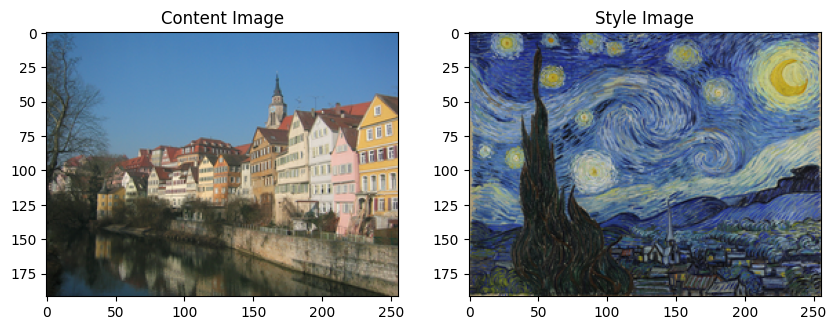

In [22]:
# local image locations
content_path = "./input/tubingen.jpg"
style_path = "./input/starry-night.jpg"

content = load_file(content_path)
style = load_file(style_path)

# show sample input images
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plot_im(content, "Content Image")
plt.subplot(1, 2, 2)
plot_im(style, "Style Image")
plt.show()

In [23]:
# func preprocess image for vgg19 input
def img_preprocess(img_path):
    image = load_file(img_path)
    img = tf.keras.applications.vgg19.preprocess_input(image)
    return img


# func deprocess image
# code adapted from chapter 8.3 Deep Learning with Python - Francois Challot
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)

    # input dimension must be [1, height, width, channel] or [height, width, channel]
    assert len(x.shape) == 3

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # convert image from BGR to RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [24]:
# layers used in content/style loss
content_layer = ["block5_conv2"]
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# weights
# total_variation_weight = 1e-4
# style_weight = 1.0
# content_weight = 0.025

count_content = len(content_layer)
count_style = len(style_layers)

In [25]:
# func get pretrained vgg weights
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    content_output = [vgg.get_layer(layer).output for layer in content_layer]
    style_output = [vgg.get_layer(layer).output for layer in style_layers]
    model_output = style_output + content_output

    return models.Model(vgg.input, model_output)

In [26]:
# inspect the vgg19 model
model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet")
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [27]:
# func get the content loss (root mean squared)
def get_content_loss(noise, target):
    loss = tf.reduce_mean(tf.square(noise - target))
    return loss


# func construct gram matrix from style layers
def gram_matrix(x):
    channels = int(x.shape[-1])
    vector = tf.reshape(x, [-1, channels])
    n = tf.shape(vector)[0]
    matrix = tf.matmul(vector, vector, transpose_a=True)
    gram = matrix / tf.cast(n, tf.float32)
    return gram


# func get the style loss (difference in gram between target and noise)
def get_style_loss(noise, target):
    gram_noise = gram_matrix(noise)
    # gram_target=gram_matrix(target)
    loss = tf.reduce_mean(tf.square(target - gram_noise))
    return loss

In [28]:
def get_features(model, content_path, style_path):
    content_img = img_preprocess(content_path)
    style_image = img_preprocess(style_path)

    content_output = model(content_img)
    style_output = model(style_image)

    content_features = [layer[0] for layer in content_output[count_style:]]
    style_features = [layer[0] for layer in style_output[:count_style]]
    return content_features, style_features

In [29]:
# func compute total loss between content and style
# code adapted from https://www.kaggle.com/code/tarunbisht11/generate-art-using-fast-style-transfer-in-a-second
def compute_loss(model, loss_weights, image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    output = model(image)
    content_loss = 0
    style_loss = 0

    noise_style_features = output[:count_style]
    noise_content_feature = output[count_style:]

    weight_per_layer = 1.0 / float(count_style)
    for a, b in zip(gram_style_features, noise_style_features):
        style_loss += weight_per_layer * get_style_loss(b[0], a)

    weight_per_layer = 1.0 / float(count_content)
    for a, b in zip(noise_content_feature, content_features):
        content_loss += weight_per_layer * get_content_loss(a[0], b)

    style_loss *= style_weight
    content_loss *= content_weight

    total_loss = content_loss + style_loss

    return total_loss, style_loss, content_loss


# func calculate gradient
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**dictionary)

    total_loss = all_loss[0]
    return tape.gradient(total_loss, dictionary["image"]), all_loss

In [30]:
# func run the style transfer
# code adapted from https://www.kaggle.com/code/tarunbisht11/generate-art-using-fast-style-transfer-in-a-second
def run_style_transfer(
    content_path, style_path, epochs=500, content_weight=1e3, style_weight=1e-3
):

    model = get_model()

    for layer in model.layers:
        layer.trainable = False

    content_feature, style_feature = get_features(model, content_path, style_path)
    style_gram_matrix = [gram_matrix(feature) for feature in style_feature]

    noise = img_preprocess(content_path)
    noise = tf.Variable(noise, dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss, best_img = float("inf"), None

    loss_weights = (style_weight, content_weight)
    dictionary = {
        "model": model,
        "loss_weights": loss_weights,
        "image": noise,
        "gram_style_features": style_gram_matrix,
        "content_features": content_feature,
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    all_images = []
    for i in range(epochs):
        grad, all_loss = compute_grads(dictionary)
        total_loss, style_loss, content_loss = all_loss
        optimizer.apply_gradients([(grad, noise)])
        clipped = tf.clip_by_value(noise, min_vals, max_vals)
        noise.assign(clipped)

        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())

        # for visualization

        if i % 5 == 0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            all_images.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print("Epoch: {}".format(i))
            print(
                "Total loss: {:.4e}, "
                "style loss: {:.4e}, "
                "content loss: {:.4e}, ".format(total_loss, style_loss, content_loss)
            )

    IPython.display.clear_output(wait=True)

    return best_img, best_loss, all_images

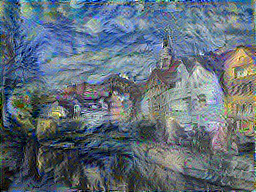

Epoch: 495
Total loss: 3.9431e+05, style loss: 1.9279e+05, content loss: 2.0152e+05, 


In [31]:
# content_path = "./input/golden_gate.jpg"
content_path = "./input/tubingen.jpg"
style_path = "./input/starry-night.jpg"
# style_path = "./input/kandinsky.jpg"

# total_variation_weight = 1e-4
CONTENT_WEIGHT = 1e3
STYLE_WEIGHT = 1e-3

# output images (arrays)
best_image, best_loss, all_images = run_style_transfer(
    content_path,
    style_path,
    epochs=500,
    content_weight=CONTENT_WEIGHT,
    style_weight=STYLE_WEIGHT,
)

In [32]:
# save the image
im = Image.fromarray(best_image)
im.save("./output/starry-tubingen.png")

### Playing with the Weights

In [33]:
# plt.figure(figsize=(15, 15))
# plt.subplot(1, 3, 3)
# plt.imshow(all_images[99])
# plt.title("Output")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1, 3, 1)
# plot_im(content, f"Content Image (w={content_weight})")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1, 3, 2)
# plot_im(style, f"Style Image (w={style_weight})")
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [34]:
# plt.figure(figsize=(15, 15))
# plt.subplot(1, 3, 3)
# plt.imshow(best_image)
# plt.title("Output")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1, 3, 1)
# plot_im(content, f"Content Image (w={content_weight})")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1, 3, 2)
# plot_im(style, f"Style Image (w={style_weight})")
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [35]:
# plt.figure(figsize=(15, 15))
# plt.subplot(1, 3, 3)
# plt.imshow(best_image)
# plt.title("Output")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1, 3, 1)
# plot_im(content, f"Content Image (w={content_weight})")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1, 3, 2)
# plot_im(style, f"Style Image (w={style_weight})")
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [36]:
# plt.figure(figsize=(15, 15))
# plt.subplot(1, 3, 3)
# plt.imshow(best_image)
# plt.title("Output")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1, 3, 1)
# plot_im(content, f"Content Image (w={content_weight})")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1, 3, 2)
# plot_im(style, f"Style Image (w={style_weight})")
# plt.xticks([])
# plt.yticks([])
# plt.show()

### Observations & Thoughts
- There is a noticable difference in the output depending on the weights

- The output does see some bias quality improvement if the two input images somewhat complement each other
    <br/>eg. Two scenic photos, or minimal content and heavily abstract style

- The subjective quantity at which to set the content-to-style ratio is highly dependent on the input, although generally more on the style
    <br/>eg. Kandinsky's works are at a higher abstraction level compared to Van Gough's, therefore another tenfold on the style weight seems more appealing
    
- With the point above, training style-per-model methods don't seem completely like terrible approach anymore, the fidelity will better match one artist

## Video Style Transfer

In this section we're going to extend basic NST to video style transfer (VST) using a basic method by applying the stylization to each individual frame of a short video. Epoch count will be lowered and default resolution will also be minimized to reduce computational time.

A GIF from the movie "Sintel" we're going to sample (free public movie from [Blender Foundation](https://durian.blender.org/about/))

![Sintel Movie Sample](./input/sintel-sample.gif)

In [37]:
# func extract single frames from a gif
def extract_frames(gif_path, num_key_frames):
    all_frames = []
    key_frames = []

    im = Image.open(gif_path)
    im.seek(0)
    for i in range(im.n_frames):
        im.seek(i)
        frame = np.array(im.convert("RGBA").convert("RGB"))  # clean header
        all_frames.append(frame)

        # extract only key frames
        if i % (im.n_frames // num_key_frames + 1) == 0:
            key_frames.append({"fn": i, "img": frame})

    print(f"all extracted frames: {len(all_frames)}, key frames: {len(key_frames)}")
    return all_frames, key_frames


# func plot the key frames
def plot_key_frames(key_frames, num_frames):
    plt.figure(figsize=(max(12, num_frames * 3), 8))
    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(np.uint8(key_frames[i]["img"]))
        plt.title(f"f{key_frames[i]['fn']}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

all extracted frames: 50, key frames: 8


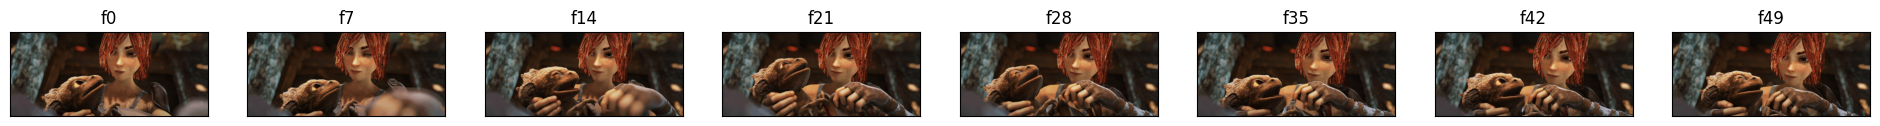

In [38]:
input_gif_path = "./input/sintel-sample.gif"
NUM_KEY_FRAMES = 8

all_frames, key_frames = extract_frames(input_gif_path, NUM_KEY_FRAMES)
plot_key_frames(key_frames, NUM_KEY_FRAMES)

In [39]:
# func convert an array of numpy images into a gif
def convert_to_gif(frames, name=""):
    output_path = f"./output/{name}.gif"
    gif = []

    for frame in frames:
        im_frame = Image.fromarray(frame)
        gif.append(im_frame)

    gif[0].save(
        output_path,
        save_all=True,
        append_images=gif[1:],
        optimize=False,
        duration=40,
        loop=0,
    )


convert_to_gif(all_frames, "test_gif")

![Output Gif](./output/test_gif.gif)

In [17]:
# naively apply NST to each frame individually
CONTENT_WEIGHT = 1e3
STYLE_WEIGHT = 1e-3

styled_frames = []
styled_key_frames = []
# content path is the array of frames generated from the gif
style_path = "./input/starry-night.jpg"


# main stylization loop
for i, frame in enumerate(all_frames):
    content_frame = Image.fromarray(frame)
    best_image, best_loss, all_images = run_style_transfer(
        content_frame,
        style_path,
        epochs=300,
        content_weight=CONTENT_WEIGHT,
        style_weight=STYLE_WEIGHT,
    )

    # styled frames
    styled_frames.append(best_image)

    # styled key frames
    if i % (im.n_frames // NUM_KEY_FRAMES + 1) == 0:
        styled_key_frames.append({"fn": i, "img": best_image})

NameError: name 'all_frames' is not defined

In [ ]:
# convert stylzed frames as a gif
convert_to_gif(styled_frames, "stylized_sintel_naive")

![Stylized Sintel (No Temporal Coherence)](./output/stylized_sintel_naive.gif)

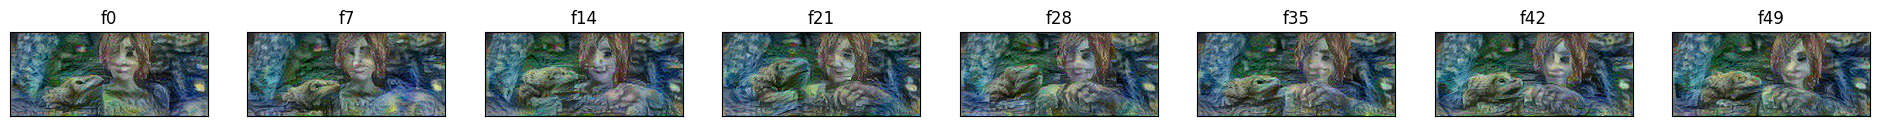

In [ ]:
# plot the styled key frames
plot_key_frames(styled_key_frames, NUM_KEY_FRAMES)

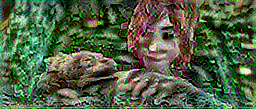

Epoch: 195
Total loss: 2.9619e+05, style loss: 6.5729e+04, content loss: 2.3046e+05, 


In [ ]:
# with temporal coherence (TC) apply NST to each frame individually
CONTENT_WEIGHT = 1e3
STYLE_WEIGHT = 1e-3

tc_frames = []
tc_key_frames = []
prev_images = []
# content path is the array of frames generated from the gif
style_path = "./input/starry-night.jpg"


# main stylization loop with TC
for i, frame in enumerate(all_frames):
    content_frame = Image.fromarray(frame)
    if tc_frames:
        style_path = Image.fromarray(tc_frames[-1])
    best_image, best_loss, all_images = run_style_transfer(
        content_frame,
        style_path,
        epochs=200,
        content_weight=CONTENT_WEIGHT,
        style_weight=STYLE_WEIGHT,
    )
    prev_images = all_images

    # styled TC frames
    tc_frames.append(best_image)

    # styled TC key frames
    if i % (im.n_frames // NUM_KEY_FRAMES + 1) == 0:
        tc_key_frames.append({"fn": i, "img": best_image})

In [ ]:
# convert stylzed frames as a gif
convert_to_gif(tc_frames, "stylized_sintel_tc")

![Stylized Sintel (Minimal Temporal Coherence)](./output/stylized_sintel_tc.gif)

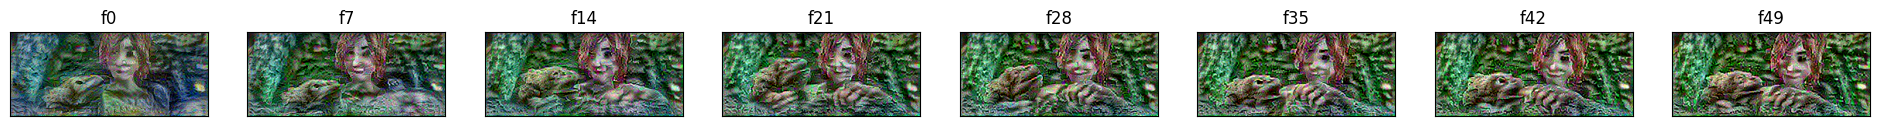

In [382]:
# plot the styled key frames
plot_key_frames(tc_key_frames, NUM_KEY_FRAMES)

### Observations & Thoughts 2

- The first stylized GIF actually turns out not too bad, although it took a long time to stylize all 50 frames even with reduced resolution
- As expected, there is a lot of artefacts and unstable moving textures

- With a basic temporal coherence attempt, the finished GIF has noticably less noise, but losses almost all style
- I can start to understand why there is a major style loss when attempting to apply any temporal coherence, more weight on the original frame makes for smoother transitions, however this means little to no style weight
- Leads me to the notion that the loss function has to be rewritten and expanded to incorporate more inputs and other factors such as optical flow